In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
# Veri kümesini yükleme
data = pd.read_csv("/content/gdrive/My Drive/melbourne_data/Melbourne_housing_FULL.csv")

# Veri kümesinin ilk 5 satırını görüntüleme
ilk_bes_satir = data.head()
print("İlk 5 Satır:")
print(ilk_bes_satir)

# Veri kümesinin şekli
satir_sayisi, sutun_sayisi = data.shape
print(f"Veri Kümesinin Şekli: {satir_sayisi} satır, {sutun_sayisi} sütun")

# Sütun sayısı
sutun_sayisi = len(data.columns)
print(f"Sütun Sayısı: {sutun_sayisi}")

# Sütun etiketleri
sutun_etiketleri = data.columns
print("Sütun Etiketleri:")
print(sutun_etiketleri)

# Sütun veri tipleri
sutun_veri_tipleri = data.dtypes
print("Sütun Veri Tipleri:")
print(sutun_veri_tipleri)

# Bellek kullanımı
bellek_kullanimi = data.memory_usage(deep=True)
print("Bellek Kullanımı:")
print(bellek_kullanimi)

# Boş olmayan hücre sayısı
hucresiz_sayisi = data.count()
print("Boş Olmayan Hücre Sayısı:")
print(hucresiz_sayisi)


İlk 5 Satır:
       Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt         CouncilArea Lattitude  Longtitude 

In [4]:
#veri setini kopyalama
data_copy = data.copy()

In [5]:
#object türündeki verileri category tipine dönüştürme
categorical_columns = data_copy.select_dtypes(include=["object"]).columns
data_copy[categorical_columns] = data_copy[categorical_columns].astype('category')

In [6]:
data_info = data_copy.dtypes
print(data_info)

Suburb           category
Address          category
Rooms               int64
Type             category
Price             float64
Method           category
SellerG          category
Date             category
Distance          float64
Postcode          float64
Bedroom2          float64
Bathroom          float64
Car               float64
Landsize          float64
BuildingArea      float64
YearBuilt         float64
CouncilArea      category
Lattitude         float64
Longtitude        float64
Regionname       category
Propertycount     float64
dtype: object


In [7]:
#veri kumesindeki tanımlayici istatistikleri incelemek icin
descriptive_stats = data_copy.describe()
print(descriptive_stats)
#aykırı degerleri gorebilmemiz icin asagidaki veriler yardımcı oluyor

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  34857.000000  2.724700e+04  34856.000000  34856.000000  26640.000000   
mean       3.031012  1.050173e+06     11.184929   3116.062859      3.084647   
std        0.969933  6.414671e+05      6.788892    109.023903      0.980690   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.350000e+05      6.400000   3051.000000      2.000000   
50%        3.000000  8.700000e+05     10.300000   3103.000000      3.000000   
75%        4.000000  1.295000e+06     14.000000   3156.000000      4.000000   
max       16.000000  1.120000e+07     48.100000   3978.000000     30.000000   

           Bathroom           Car       Landsize  BuildingArea     YearBuilt  \
count  26631.000000  26129.000000   23047.000000   13742.00000  15551.000000   
mean       1.624798      1.728845     593.598993     160.25640   1965.289885   
std        0.724212      1.010771    3398.841946

In [8]:
# Tekrarlanan Verileri Kontrol Et ve Temizle
duplicated_rows = data_copy[data_copy.duplicated()]
if not duplicated_rows.empty:
    print("Tekrarlanan Veriler:")
    print(duplicated_rows)
    data = data_copy.drop_duplicates()

Tekrarlanan Veriler:
           Suburb        Address  Rooms Type  Price Method SellerG  \
15858  Nunawading  1/7 Lilian St      3    t    NaN     SP  Jellis   

             Date  Distance  Postcode  ...  Bathroom  Car  Landsize  \
15858  17/06/2017      15.4    3131.0  ...       3.0  2.0     405.0   

       BuildingArea  YearBuilt              CouncilArea Lattitude  Longtitude  \
15858         226.0     2000.0  Manningham City Council -37.82678   145.16777   

                 Regionname Propertycount  
15858  Eastern Metropolitan        4973.0  

[1 rows x 21 columns]


In [9]:
from scipy import stats

# Aykırı değerleri tespit etmek için z-skor eşik değerini belirleme genel olarak 3
z_score_threshold = 3

# Aykırı değerleri tutmak için boş bir DataFrame
outliers = pd.DataFrame()

# Aykırı değer tespiti için sayısal sütunları döngüye alıyoruz
numerical_columns = data_copy.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    z_scores = np.abs(stats.zscore(data_copy[column]))

    # Z-skoru eşik değeriyle karşılaştır ve aykırı değerleri seç
    outliers[column] = data_copy[column][z_scores > z_score_threshold]

# Aykırı değerleri yazdır
print("Aykırı Değerler:")
print(outliers)


Aykırı Değerler:
       Rooms  Price  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  \
81         6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
175        7    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
426        6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
496        6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
538        6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
...      ...    ...       ...       ...       ...       ...  ...       ...   
34212      6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
34367      6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
34412      6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
34494      6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   
34770      6    NaN       NaN       NaN       NaN       NaN  NaN       NaN   

       BuildingArea  YearBuilt  Lattitude  Lon

In [10]:
# Aykırı değerleri temizle
data_copy = data_copy[~data_copy.isin(outliers)].dropna()

# Veri boyutunu kontrol et
print("Temizlenmiş Veri Boyutu:", data_copy.shape)

Temizlenmiş Veri Boyutu: (8823, 21)


In [11]:
# Eksik verileri doldur (sayısal sütunlar için ortalama, kategorik sütunlar için mod kullanarak)
for column in data_copy.columns:
    if data_copy[column].dtype == 'float64' and 'int64':
        data_copy[column].fillna(data_copy[column].mean(), inplace=True)
    elif data_copy[column].dtype.name == 'category':
        if data_copy[column].isna().any():
            data_copy[column].fillna(data_copy[column].mode().iloc[0], inplace=True)


In [12]:
print("Veri Boyutu:", data_copy.shape)

Veri Boyutu: (8823, 21)


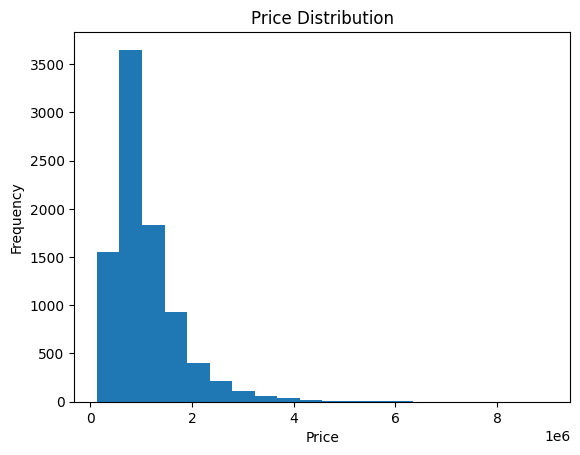

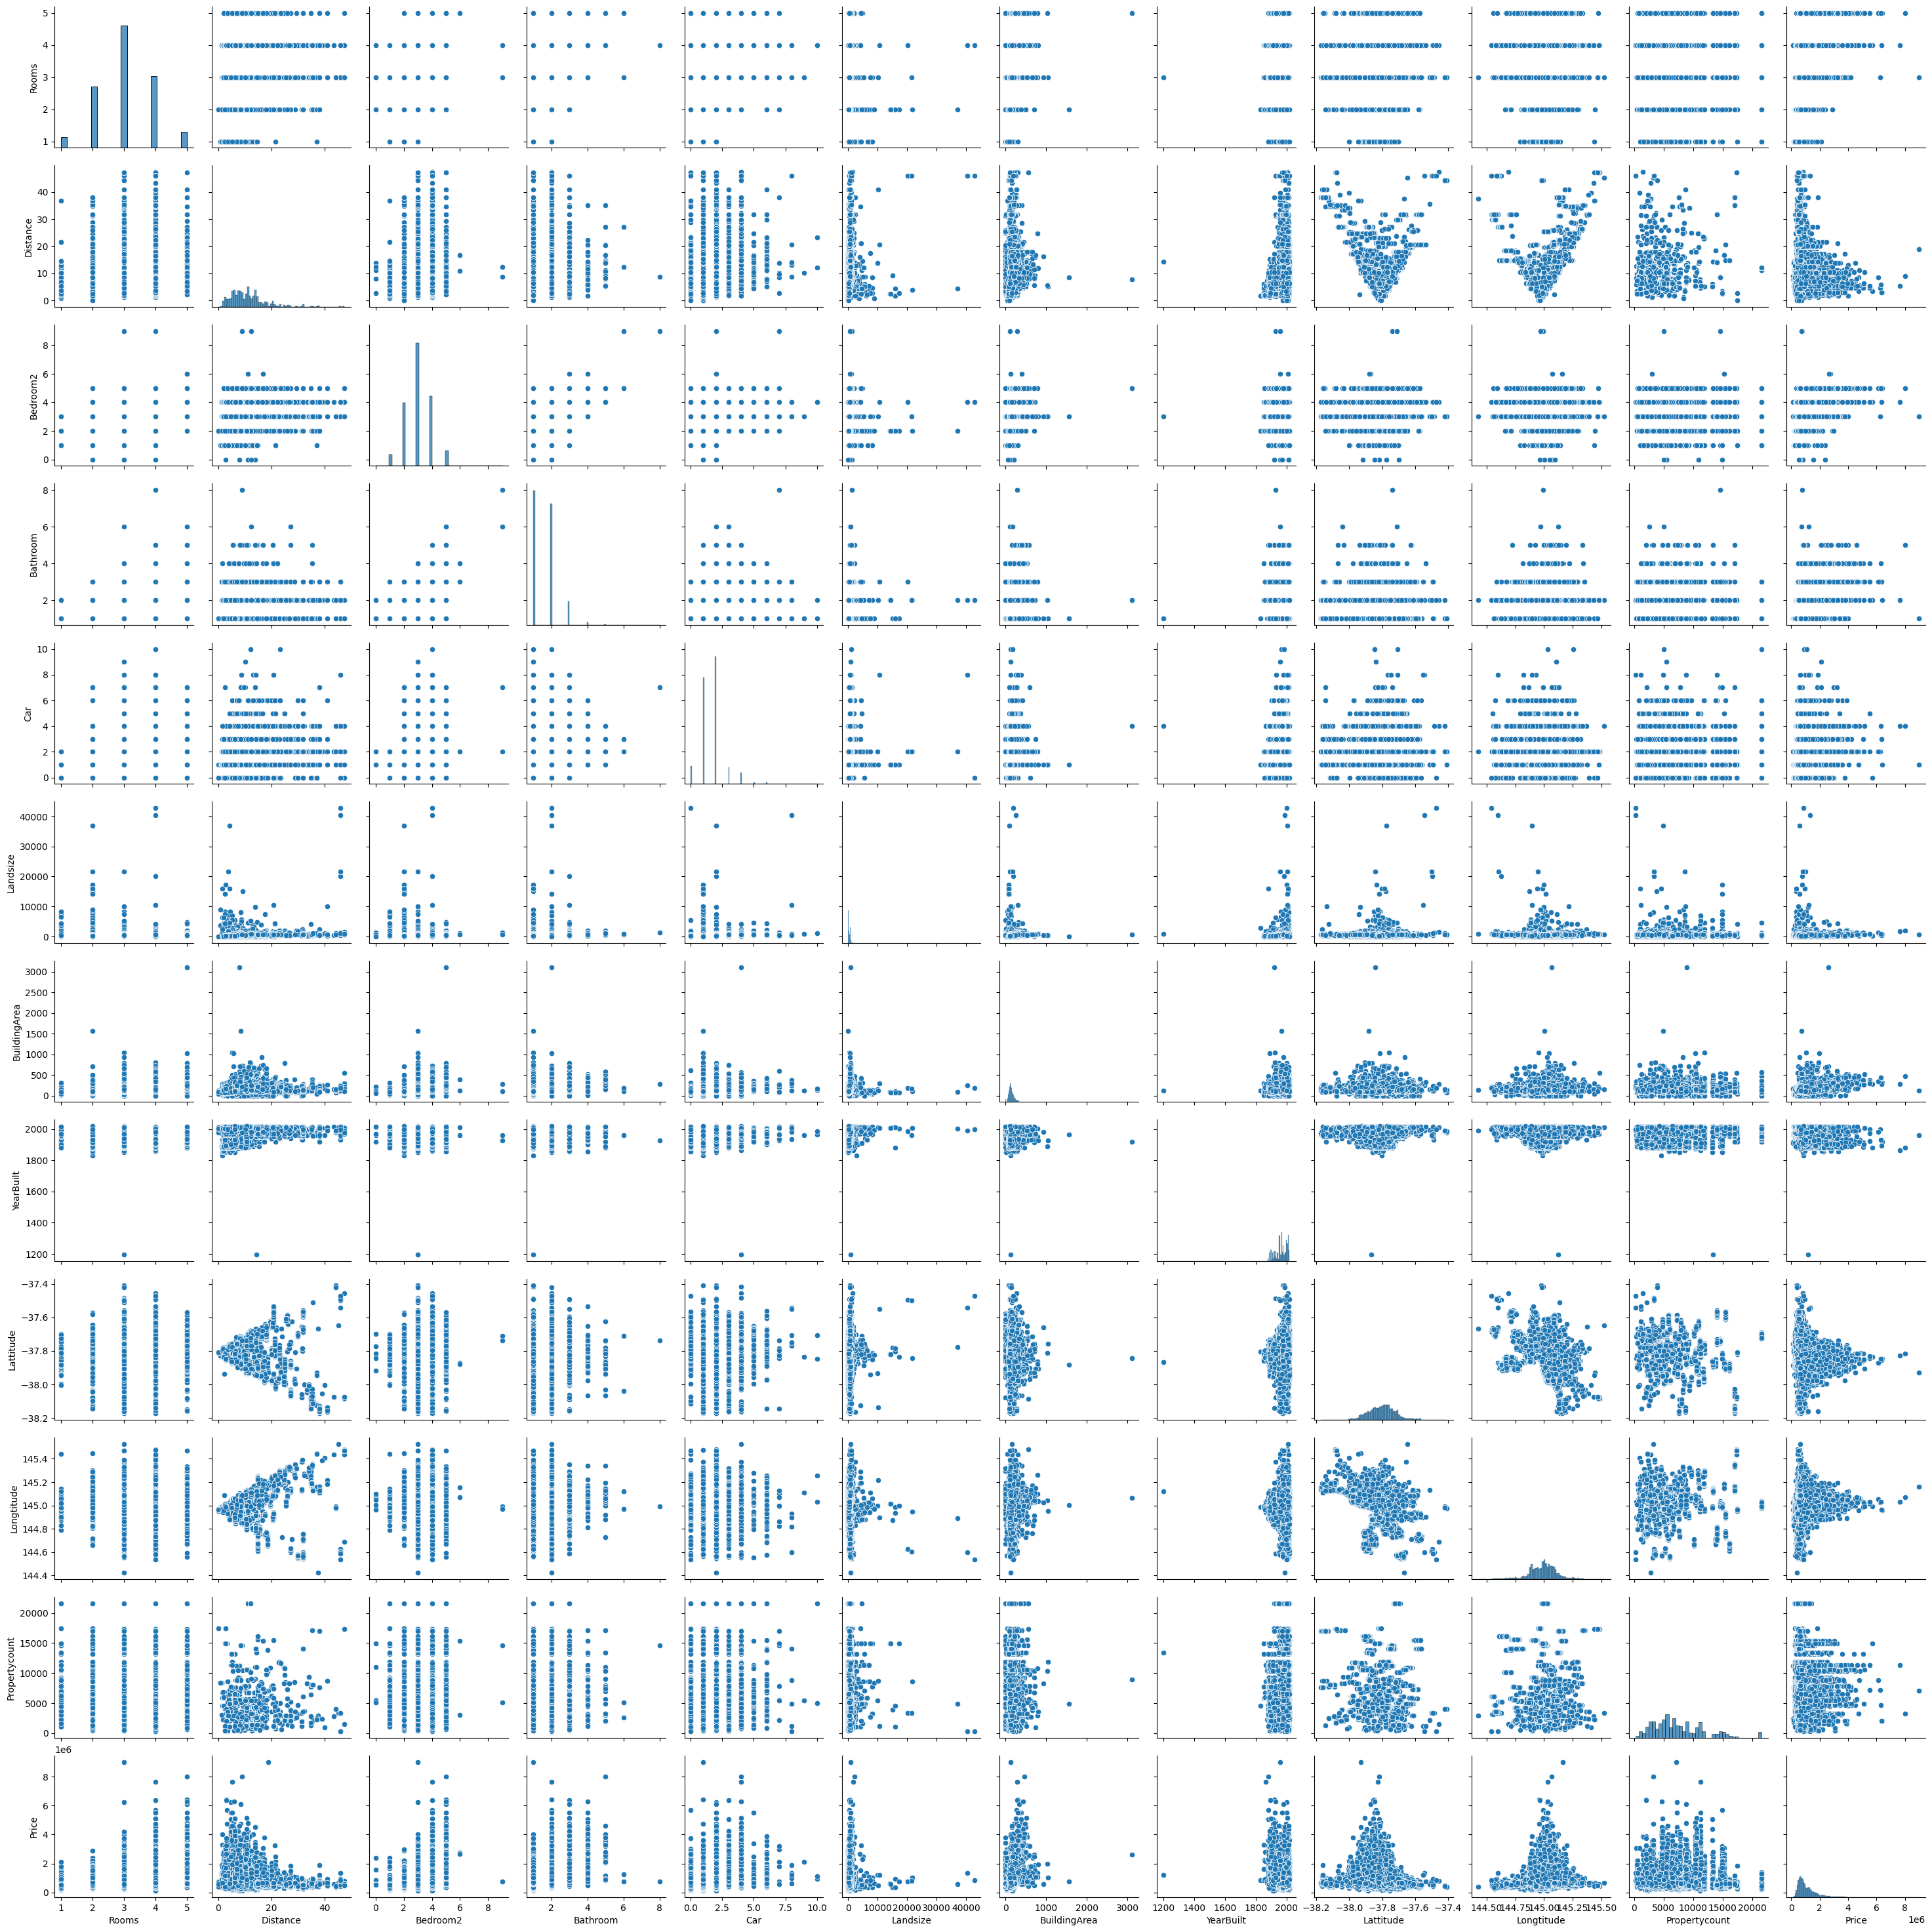

In [13]:
# Veriyi görselleştirme
plt.hist(data_copy['Price'], bins=20)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

sns.pairplot(data_copy, vars=['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount', 'Price'])
plt.show()

<ipython-input-14-e64f1d5ec183>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_copy.corr()


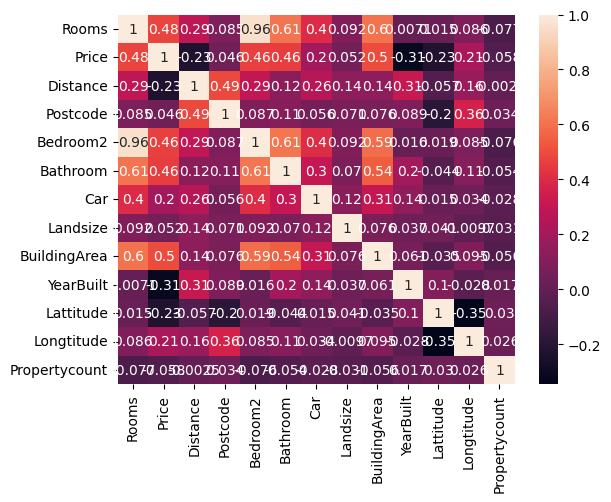

In [14]:
correlation_matrix = data_copy.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Kategorik sütunları LabelEncoder veya OneHotEncoder ile dönüştürün
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
for column in data_copy.columns:
    if data_copy[column].dtype.name == 'category':
        data_copy[column] = label_encoder.fit_transform(data_copy[column])

In [14]:
# Bağımsız değişkenler (X) ve bağımlı değişken (y) belirleyin
X = data_copy.drop(columns=['Price', 'Date','YearBuilt'])
y = data_copy['Price']

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Veriyi eğitim ve test verilerine bölin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Modelleri tanımlayın
models = {
    'Lasso': {'model': Lasso()},
    'LinearRegression': {'model': LinearRegression()},
    'Ridge': {'model': Ridge()},
    'ElasticNet': {'model': ElasticNet()},
    'KNeighborsRegressor': {'model': KNeighborsRegressor()},
    'RandomForestRegressor': {'model': RandomForestRegressor()},
    'GradientBoostingRegressor': {'model': GradientBoostingRegressor()},
    'AdaBoostRegressor': {'model': AdaBoostRegressor(n_estimators=5, learning_rate=1.2, loss='exponential', random_state=2)}
}

In [28]:
categorical_columns = data_copy.select_dtypes(include=['category']).columns

# Veri setinde tipi "category" olan sütunları seç
categorical_data = data_copy[categorical_columns]

# One-Hot Encoding uygulayarak kategorik sütunları dönüştür
data_copy = pd.get_dummies(data_copy, columns=categorical_columns)


In [17]:
data_info = data_copy.dtypes
print(data_info)


Suburb             int64
Address            int64
Rooms            float64
Type               int64
Price            float64
Method             int64
SellerG            int64
Date               int64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea        int64
Lattitude        float64
Longtitude       float64
Regionname         int64
Propertycount    float64
dtype: object


In [18]:
# Modelleri eğitin ve performansı değerlendirin
results = {}
for model_name, model_info in models.items():
    model = model_info['model']
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

In [19]:
# En iyi performans gösteren modeli seçin
best_model = min(results, key=lambda k: results[k]['RMSE'])

In [20]:
print("Model Performansı:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  R2: {metrics['R2']:.2f}")
    print()

print(f"En İyi Model: {best_model}")

Model Performansı:
Lasso:
  MAE: 270551.32
  MSE: 160857192243.44
  RMSE: 401070.06
  R2: 0.63

LinearRegression:
  MAE: 270551.77
  MSE: 160857591673.96
  RMSE: 401070.56
  R2: 0.63

Ridge:
  MAE: 270548.54
  MSE: 160855678957.00
  RMSE: 401068.17
  R2: 0.63

ElasticNet:
  MAE: 298408.86
  MSE: 189069969964.19
  RMSE: 434821.77
  R2: 0.57

KNeighborsRegressor:
  MAE: 394802.10
  MSE: 351452763517.21
  RMSE: 592834.52
  R2: 0.20

RandomForestRegressor:
  MAE: 154629.77
  MSE: 67885440668.46
  RMSE: 260548.35
  R2: 0.85

GradientBoostingRegressor:
  MAE: 170116.19
  MSE: 74014442242.49
  RMSE: 272055.95
  R2: 0.83

AdaBoostRegressor:
  MAE: 331584.02
  MSE: 200160258174.12
  RMSE: 447392.73
  R2: 0.54

En İyi Model: RandomForestRegressor
